In [26]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [27]:
df = pd.read_csv('C:\\Users\\ASUS\\Desktop\\Python\\sales.csv', parse_dates = ['YearMonth'], index_col = ['YearMonth'])

# This is the sales data of a store from the year 2013 to 2018

In [28]:
df.head(1)

,Sales
YearMonth,
2013-01-01,352668.0862


In [44]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(df,train_size=0.8,test_size=0.2,shuffle=False)

In [74]:
rolling_mean = df.rolling(window = 12).mean()
rolling_stdev = df.rolling(window = 12).std()

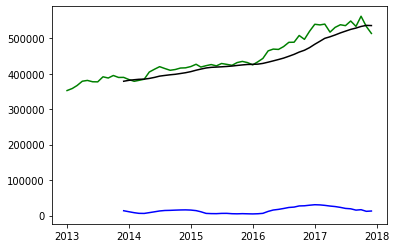

In [75]:
plt.plot(df, color = 'green', label = 'Original')
plt.plot(rolling_mean, color = 'black', label = 'Rolling mean')
plt.plot(rolling_stdev, color = 'blue', label = 'Rolling std. dev')

In [76]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Writing a function for getting stationarity of the series

In [77]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['Sales'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

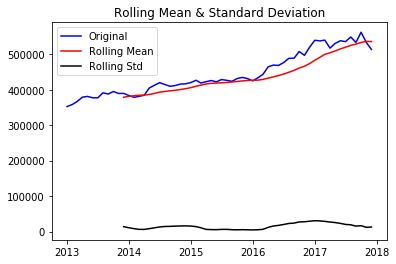

ADF Statistic: -0.5226825393994348
p-value: 0.8875136308020727
Critical Values:
	1%: -3.5745892596209488
	5%: -2.9239543084490744
	10%: -2.6000391840277777


In [34]:
get_stationarity(df) # series is not stationary

# Since the the series is not stationary, we need to apply various transformations to make it stationary

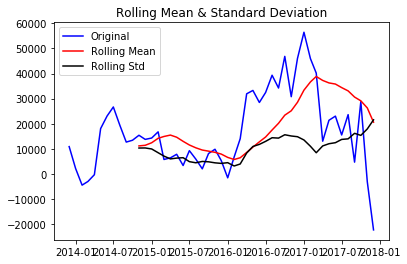

ADF Statistic: -1.7079508852450238
p-value: 0.4270206677950841
Critical Values:
	1%: -3.6209175221605827
	5%: -2.9435394610388332
	10%: -2.6104002410518627


In [78]:
rolling_mean = df.rolling(window=12).mean()
df_minus_mean = df - rolling_mean
df_minus_mean.dropna(inplace=True)
get_stationarity(df_minus_mean)

# subtracting Rolling Mean does not bring stationarity in series

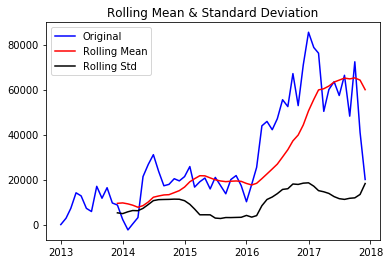

ADF Statistic: -1.5742986805171348
p-value: 0.49648995480876684
Critical Values:
	1%: -3.5745892596209488
	5%: -2.9239543084490744
	10%: -2.6000391840277777


In [80]:
rolling_mean_exp_decay = df.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_exp_decay = df - rolling_mean_exp_decay
df_exp_decay.dropna(inplace=True)
get_stationarity(df_exp_decay)

# Applying exponential decay to rolling mean does not bring stationarity in series

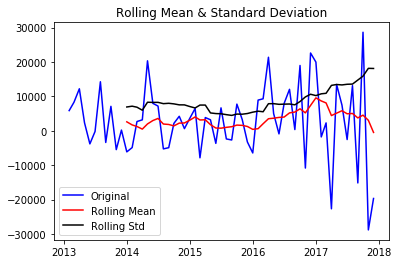

ADF Statistic: -2.0836873976256824
p-value: 0.25112436748686884
Critical Values:
	1%: -3.5745892596209488
	5%: -2.9239543084490744
	10%: -2.6000391840277777


In [81]:
df_shift = df - df.shift(1)
df_shift.dropna(inplace=True)
get_stationarity(df_shift)

#  In above transformation ADF Stats is near to critical value and rolling stats seems to be stationary

In [82]:

from statsmodels.graphics.tsaplots import plot_pacf

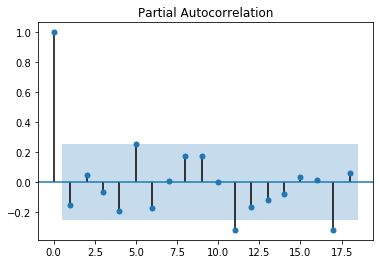

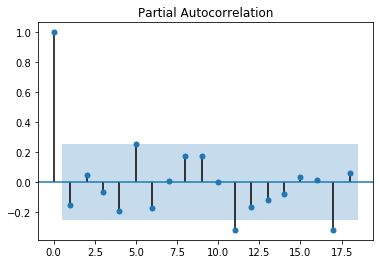

In [83]:
plot_pacf(df_shift)

# PCAF helps us to decide the value of 'd' in 'pdq' parameters of ARIMA 
# Since here the attenuation of of PCAF occurs immediately after one shift, we can take 'd' = 1

C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


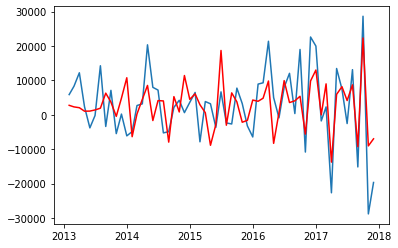

In [53]:
decomposition = seasonal_decompose(df) 
model = ARIMA(df, order=(9,1,10))
results = model.fit(disp=-1)
plt.plot(df_shift)
plt.plot(results.fittedvalues, color='red')

# From the above plot we can infer that 'p = 9' and 'q = 10' gives us the optimal fit

In [54]:
print(results.aic)

1271.5527161256555


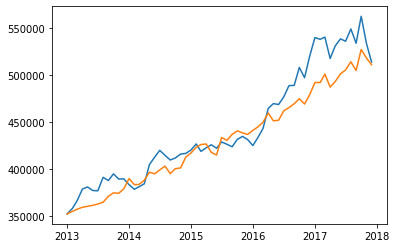

In [57]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA = pd.Series(df['Sales'].iloc[0], index=df.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff_cumsum, fill_value=0)

plt.plot(df)
plt.plot(predictions_ARIMA)

# In the above plot the yellow line shows the Sales forcast by ARIMA model  and BLue line shows the original Sales value

In [58]:
predictions_ARIMA.head()

YearMonth
2013-01-01    352668.086200
2013-02-01    355399.940661
2013-03-01    357674.442335
2013-04-01    359712.220321
2013-05-01    360740.582222
dtype: float64

In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [65]:
mean_squared_error(y_true=df['Sales'],
                   y_pred=predictions_ARIMA)

417536788.41488427

In [66]:
np.sqrt(mean_squared_error(y_true=df['Sales'],
                   y_pred=predictions_ARIMA))

20433.71695054241

In [69]:
mean_absolute_error(y_true=df['Sales'],
                   y_pred=predictions_ARIMA)

16387.6570137402

In [70]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=df['Sales'],
                   y_pred=predictions_ARIMA)

3.515173634044153

# Error Metrics
# MSE is 417536788.41488427
# RMSE is 20433.71695054241
# MAE is 16387.6570137402
# MAPE is 3.51%